In [191]:
import pickle
import numpy as np
import qiskit
from qiskit.transpiler import Layout
from qiskit.opflow.state_fns import DictStateFn
from qiskit.opflow import I, X, Y, Z, CircuitOp, StateFn
from qiskit import QuantumCircuit

import math

import argparse
import os
from functools import partial

import numpy as np
import networkx as nx
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation, PauliExpectation, StateFn, DictStateFn, CircuitStateFn, Z
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import Maxcut, SKModel
# from qiskit_optimization.translators import from_docplex_mp
from qiskit.utils import algorithm_globals
# from docplex.mp.model import Model
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from qiskit.quantum_info.analysis import hellinger_fidelity

from qiskit.converters import circuit_to_dag


In [205]:
from QAOAKit.utils import maxcut_obj, obj_from_statevector, get_adjacency_matrix

def get_energy(G, qc: QuantumCircuit=None, cnts: dict=None):
    # print(qc)
    # qc.save_statevector()
    shots = 1024
    obj = partial(maxcut_obj, w=get_adjacency_matrix(G))
    if cnts == None:
        backend = AerSimulator(method="statevector")
        cnts = backend.run(qc, shots=shots).result().get_counts()

    obj_val = 0.0
    for bitstring, cnt in cnts.items():
        bitstring_int = np.array(list(map(int, list(bitstring))))
        obj_val += obj(bitstring_int) * (cnt / shots)
        
    return obj_val

In [206]:

parser = argparse.ArgumentParser()
parser.add_argument("--problem", type=str, default="maxcut")
parser.add_argument("-n", type=int, default=16)
parser.add_argument("-p", type=int, default=1)
parser.add_argument("-s", "--seed", type=int, default=0)
parser.add_argument("-b", "--backend", type=str, default="sv")
parser.add_argument("--cpu", default=False, action="store_true")
parser.add_argument("--no-aer", dest="aer", default=True, action="store_false")
parser.add_argument("--noise", type=str, default="ideal")
parser.add_argument("--p1", type=float, default=0.001)
parser.add_argument("--p2", type=float, default=0.005)
parser.add_argument("--beta-steps", type=int, default=50)
parser.add_argument("--gamma-steps", type=int, default=100)


_StoreAction(option_strings=['--gamma-steps'], dest='gamma_steps', nargs=None, const=None, default=100, type=<class 'int'>, choices=None, required=False, help=None, metavar=None)

In [207]:
def load_ibm_data(ibm_id: int, seed: int):
    path = f"figs/ibm/Experiments/IBM-M{ibm_id}/Experimental_Data,Seed-{seed}P=1circ_param_lst.pkl"
    print(f"read from IBM={ibm_id}, seed={seed}")
    file = open(path, 'rb')
    data = pickle.load(file)
    file.close()

    cnts_list = data[0]
    transpiled_circ = data[1][0]

    return cnts_list, transpiled_circ


def diff(a: dict, b: dict, type: str):
    diff = 0.0
    if type == 'kl':
        P = dict2arr(a)
        Q = dict2arr(b)
        diff = kl_div(P, Q)
    elif type == 'hellinger_fidelity':
        diff = hellinger_fidelity(a, b)
    elif type == 'tvd':
        P = dict2arr(a)
        Q = dict2arr(b)
        diff = total_variation_distance(P, Q)
    return diff
    # return norm_between_two_dist_in_dict_form(a, b)


def kl_div(P, Q):
    return np.sum(np.where(P * Q != 0, P * np.log(P / Q), 0))
    """ Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0. """
    # epsilon = 0.00001

    # # # You may want to instead make copies to avoid changing the np arrays.
    # P = P + epsilon
    # Q = Q + epsilon

    # divergence = np.sum(P * np.log(P / Q))
    # return divergence


def dict2arr(dist_dict: dict):
    num_qubits = len(next(iter(dist_dict)))
    arr = np.zeros(2 ** num_qubits)
    shots = np.sum(list(dist_dict.values()))
    # print("shots=", shots)
    for bitstring, cnt in dist_dict.items():
        idx = int(bitstring, 2)
        arr[idx] = 1.0 * cnt / shots
    assert np.isclose(arr.sum(), 1.0)
    return arr


def norm_between_two_dist_in_dict_form(a: dict, b: dict):
    norm = 0.0
    intersection = a.keys() & b.keys()
    for key in intersection:
        norm += (a[key] - b[key])**2

    for key in a.keys() - b.keys():
        norm += a[key] ** 2

    for key in b.keys() - a.keys():
        norm += b[key] ** 2

    return norm


def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))


In [208]:
def generate_landscape_from_transpiled_circ(args, ibm_id: int, qcs: QuantumCircuit, exp_val_type: str):
    print(args.__dict__)
    n = args.n
    p = args.p
    seed = args.seed
    backend_config = args.backend.lower()
    noise = args.noise.lower()

    if backend_config == "sv":
        method = "statevector"
    else:
        raise NotImplementedError(f"Backend {backend_config} not implemented yet")

    device = "CPU" if args.cpu else "GPU"
    backend_config += f" {noise}"
    noise_model = None

    backend = AerSimulator(
        method=method,
        device=device,
        noise_model=noise_model,
        fusion_enable=args.problem == "maxcut" or noise != "depolar" or n < 17,
    )
    backend_config = backend_config.replace(" ", "-")

    # --------------- define the problem ------------

    graph = nx.random_regular_graph(3, n, seed)
    problem = Maxcut(graph).to_quadratic_program()
    H, offset = problem.to_ising()

    algorithm_globals.random_seed = seed

    # TODO: you might need to modify this to config IBM backend
    # quantum_instance = QuantumInstance(
    #     backend=backend,
    #     seed_simulator=seed,
    #     seed_transpiler=seed,
    #     optimization_level=None,
    # )

    # algorithm = QAOA(
    #     SPSA(),
    #     reps=p,
    #     quantum_instance=quantum_instance,
    #     expectation=AerPauliExpectation() if args.aer else None,
    # )
    # algorithm._check_operator_ansatz(H)
    # energy_evaluation, expectation = algorithm.get_energy_evaluation(
    #     H, return_expectation=True
    # )

    # ------------- transpile ----------------
    # def energy_evaluation_transpiled(parameters: np.ndarray) -> float:
    #     qc = quantum_instance.transpile(algorithm.ansatz.bind_parameters(parameters))[0]
    #     observable_meas = expectation.convert(StateFn(H, is_measurement=True))
    #     expect_op = observable_meas.compose(CircuitStateFn(qc)).reduce()
    #     sampled_expect_op = algorithm._circuit_sampler.convert(expect_op)
    #     return np.real(sampled_expect_op.eval())

    # energy_evaluation = energy_evaluation_transpiled


    dirpath = f"figs/grid_search/tmp/{args.problem}/{backend_config}-{p=}"
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

    savepath = f"{dirpath}/{args.problem}-{backend_config}-{n=}-{p=}-{seed=}-{args.beta_steps}-{args.gamma_steps}-IBM{ibm_id}-transpiled-{exp_val_type}"

    if os.path.exists(f"{savepath}.npz"):
        data = np.load(
            f"{savepath}.npz",
            allow_pickle=True
        )

        return data['cnts_list'], data['data'], graph, data['offset'], H
    

    # ------------- prepare parameters and execute the circuit --------------
    data = []
    beta_bound = np.pi / 4 / p
    gamma_bound = np.pi / 2 / p

    grid = np.array(
        np.meshgrid(
            *np.linspace([-beta_bound] * p, [beta_bound] * p, args.beta_steps, axis=1),
            *np.linspace([-gamma_bound] * p, [gamma_bound] * p, args.gamma_steps, axis=1),
            indexing="ij",
        )
    )
    
    tmp = grid.transpose((*range(1, 2 * p + 1), 0)).reshape(-1, 2 * p)
    observable_meas = H
    # observable_meas = Z^6
    cnts_list = []
    for qc in tqdm(qcs): # transpiled circuit
        if exp_val_type == 'H':
            job = backend.run(qc, shots=2048)
            cnts = job.result().get_counts()
            # for bitstring, cnt in cnts.items():
            #     cnts[bitstring] = np.sqrt(cnt / 1024.0)
            cnts_list.append(cnts)
            qc = DictStateFn(job.result())
            exp_val = (~qc @ observable_meas @ qc).eval().real
        elif exp_val_type == 'graph':
            exp_val = get_energy(graph, qc)
        else:
            exp_val = 0
            
        data.append(exp_val)

        # observable_meas = expectation.convert(StateFn(H, is_measurement=True))
        # expect_op = observable_meas.compose(qc) # .reduce()
        # sampled_expect_op = algorithm._circuit_sampler.convert(expect_op)
        # energy = np.real(sampled_expect_op.eval())
        # energy = energy_evaluation(params) # ! execute the circuit
        # data.append(energy) 

    data = np.array(data).reshape(([args.beta_steps] * p) + ([args.gamma_steps] * p))

    # ----------- save the data ---------
    np.savez_compressed(
        savepath,
        data=data,
        offset=offset,
        beta_bound=beta_bound,
        gamma_bound=gamma_bound,
        grid=grid,
        cnts_list=cnts_list,
        **args.__dict__,
    )

    return cnts_list, data, graph, offset, H


In [209]:
def get_ls(G, cnts_list):
    ls = []
    for cnts in cnts_list:
        pt = get_energy(G, None, cnts)
        ls.append(pt)

    return np.array(ls).reshape((50, 100))

def get_ls_by_H(cnts_list, H):
    ls = []
    
    for cnts in cnts_list:
        primitive = {
            bstr: math.sqrt(shots / sum(cnts.values())) for (bstr, shots) in cnts.items()
        }
        qc = DictStateFn(primitive)
        exp_val = (~qc @ H @ qc).eval().real # < \psi | H | \psi >, compose()
        ls.append(exp_val)

    return np.array(ls).reshape((50, 100))

read from IBM=1, seed=0
{'problem': 'maxcut', 'n': 6, 'p': 1, 'seed': 0, 'backend': 'sv', 'cpu': True, 'aer': True, 'noise': 'ideal', 'p1': 0.001, 'p2': 0.005, 'beta_steps': 50, 'gamma_steps': 100}
norm = 0.7673131307210388
offset=-4.5


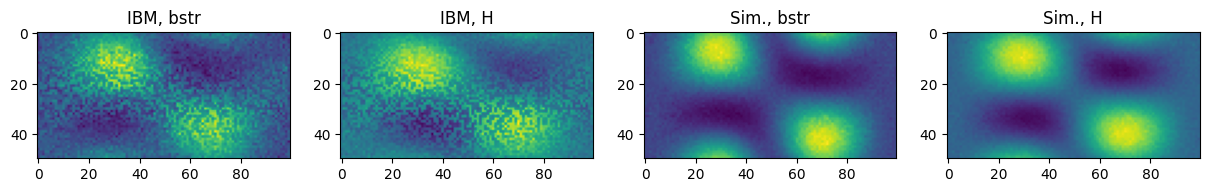

read from IBM=1, seed=1
{'problem': 'maxcut', 'n': 6, 'p': 1, 'seed': 1, 'backend': 'sv', 'cpu': True, 'aer': True, 'noise': 'ideal', 'p1': 0.001, 'p2': 0.005, 'beta_steps': 50, 'gamma_steps': 100}
norm = 0.733290673400561
offset=-4.5


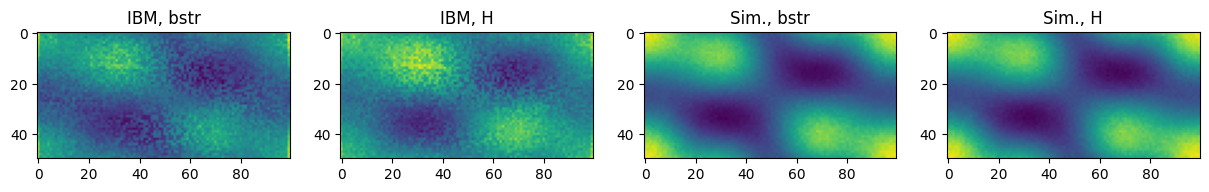

read from IBM=2, seed=0
{'problem': 'maxcut', 'n': 6, 'p': 1, 'seed': 0, 'backend': 'sv', 'cpu': True, 'aer': True, 'noise': 'ideal', 'p1': 0.001, 'p2': 0.005, 'beta_steps': 50, 'gamma_steps': 100}
norm = 0.7634650047558381
offset=-4.5


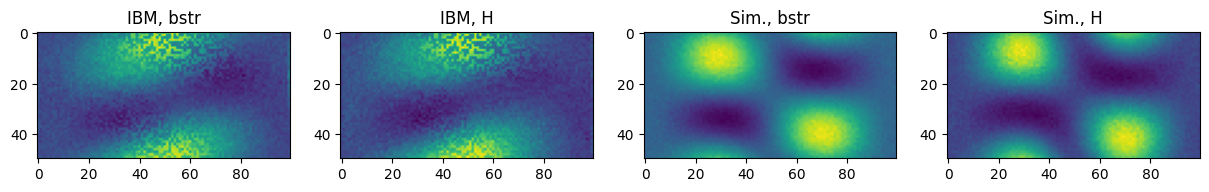

read from IBM=2, seed=1
{'problem': 'maxcut', 'n': 6, 'p': 1, 'seed': 1, 'backend': 'sv', 'cpu': True, 'aer': True, 'noise': 'ideal', 'p1': 0.001, 'p2': 0.005, 'beta_steps': 50, 'gamma_steps': 100}
norm = 0.7726658227876927
offset=-4.5


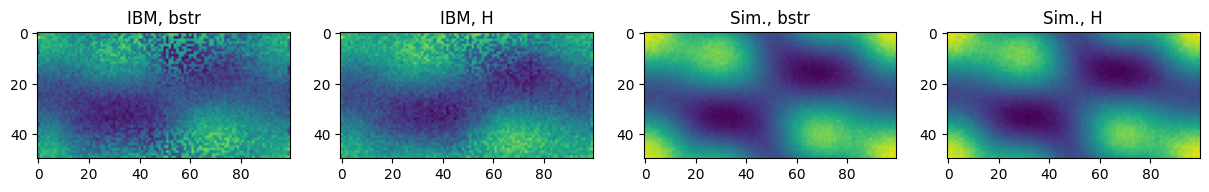

read from IBM=3, seed=0
{'problem': 'maxcut', 'n': 6, 'p': 1, 'seed': 0, 'backend': 'sv', 'cpu': True, 'aer': True, 'noise': 'ideal', 'p1': 0.001, 'p2': 0.005, 'beta_steps': 50, 'gamma_steps': 100}
norm = 0.7797872853655962
offset=-4.5


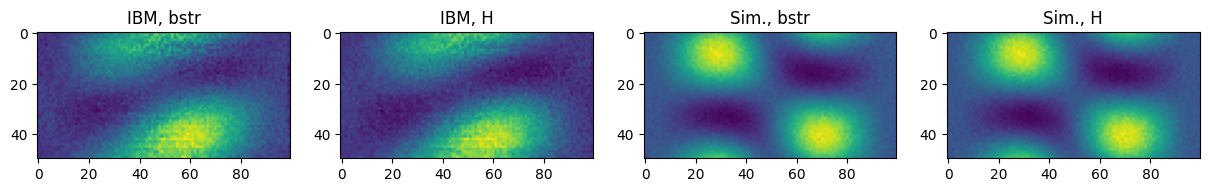

In [212]:
# check difference between counts

ibm_ids = [1, 2, 3]
seeds = [0, 1]

is_cnt_cx = False
is_graph_cost = True

for ibm in ibm_ids:
    for seed in seeds: # three instances
        if ibm == 3 and seed == 1:
            continue

        ibm_cnts_list, tcircs = load_ibm_data(ibm, seed)
        
        if is_cnt_cx:
            n_cx = 0
            for tcirc in tcircs:
                dag = circuit_to_dag(tcirc)
                # print(tcirc)
                for node in dag.topological_op_nodes():
                    if node.name == 'cx':
                        n_cx += 1

            n_cx /= len(tcircs) * 1.0
            print(n_cx)
        
        cmd = f"-n 6 -p 1 --seed {seed} --noise ideal --cpu"
        args = parser.parse_args(list(cmd.split(' ')))
        sim_cnts_list, ls, G, offset, H = generate_landscape_from_transpiled_circ(args, ibm, tcircs, 'H')
        
        norm = 0.0
        for a, b in zip(ibm_cnts_list, sim_cnts_list):
        # for a, b in zip(sim_cnts_list, ibm_cnts_list):
            norm += diff(a, b, 'hellinger_fidelity')
            # norm += diff(a, b, 'tvd')
        norm /= len(ibm_cnts_list)
        print("norm =", norm)

        if is_graph_cost:

            ibm_ls = - get_ls(G, ibm_cnts_list)
            ibm_H_ls = get_ls_by_H(ibm_cnts_list, H)

            sim_cnt_ls = - get_ls(G, sim_cnts_list)
            sim_H_ls = get_ls_by_H(sim_cnts_list, H)
            # sim_H_ls = (ls + offset)
            print(f"offset={offset}")
            
            fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 12))
            axs = axs.reshape(-1)
            idx = 0
            i = 0
            axs[i].imshow(ibm_ls)
            axs[i].set_title("IBM, bstr")

            axs[i+1].imshow(ibm_H_ls)
            axs[i+1].set_title("IBM, H")

            axs[i+2].imshow(sim_cnt_ls)
            axs[i+2].set_title("Sim., bstr")
            
            axs[i+3].imshow(sim_H_ls)
            axs[i+3].set_title("Sim., H")
            plt.show()
                        



In [86]:
# IBM 1: 32, 1.2%
# IBM 2: largos, 32, 1%
# IBM 3: aslow, coherence time is 1/3 of 1 & 2

import random
norm = 0.0
n_tries = 5000
n_qubits = 6
shots = 1024
for i in range(n_tries):

    aa = [random.randint(0, 2 ** n_qubits - 1) for _ in range(shots)]
    bb = [random.randint(0, 2 ** n_qubits - 1) for _ in range(shots)]

    a = np.zeros(2 ** n_qubits)
    b = np.zeros(2 ** n_qubits)

    for i in aa:
        # print(i)
        a[i] += 1
    
    for i in bb:
        b[i] += 1
    
    # a = np.maximum(a, 0)
    # b = np.maximum(b, 0)
    # a += a.min()
    # b += b.min()

    a /= shots
    b /= shots
    norm += kl_div(a, b)

norm /= n_tries

print(norm)

0.06347385274638323


In [53]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import expectation

from qiskit import QuantumCircuit
from qiskit.opflow import X, Z, OperatorStateFn

circuit = QuantumCircuit(2)
circuit.h(0)
# circuit.cx(0, 1)
circuit.measure_all()

observable = X @ Z

backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend)
expectation_before = expectation(OperatorStateFn(observable), circuit, quantum_instance).real


ImportError: cannot import name 'expectation' from 'qiskit.algorithms' (/Users/kunliu/miniforge3/envs/qiskit_latest/lib/python3.10/site-packages/qiskit/algorithms/__init__.py)

In [ ]:
from qiskit.compiler import transpile

transpiled_circuit = transpile(circuit, backend=backend)


In [ ]:
expectation_after = expectation(OperatorStateFn(observable), transpiled_circuit, quantum_instance).real
print(f"Expectation value before transpilation: {expectation_before}")
print(f"Expectation value after transpilation: {expectation_after}")
